In [79]:
from transformers import PaliGemmaForConditionalGeneration, AutoProcessor, Trainer , TrainingArguments 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch
import os
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader
from functools import partial
from peft import get_peft_model, LoraConfig

In [80]:
model_type='google/paligemma2-3b-pt-224'
MAX_LENGTH = 512
model = PaliGemmaForConditionalGeneration.from_pretrained(model_type,dtype=torch.bfloat16, 
                                                          device_map="auto",attn_implementation="flash_attention_2",)
processor = AutoProcessor.from_pretrained(model_type) 

c:\Users\Admin\Desktop\codes\fashion-recommender\fashion-env\Lib\site-packages\accelerate\utils\modeling.py:1566: UserWarning: Current model requires 2304 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 31.34it/s]


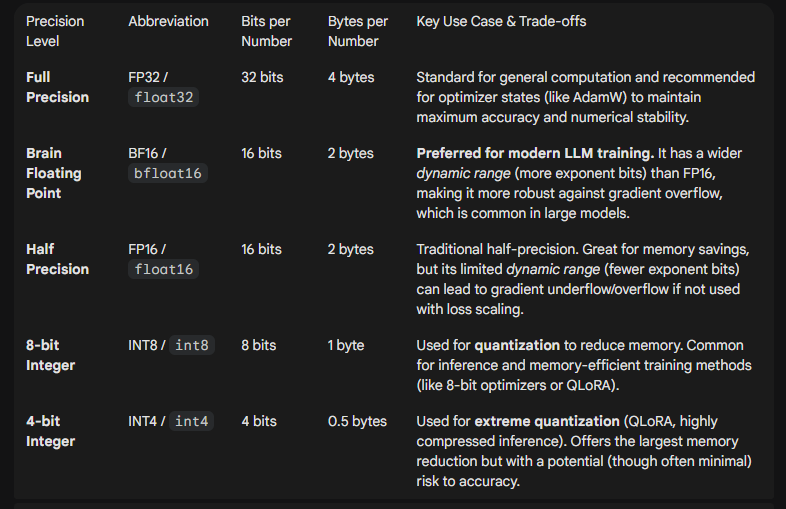

## Load Fashion Dataset

In [81]:
class FashionDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"] + ".jpg")
        image = Image.open(img_path).convert("RGB")

        return {
            "image": image,
            "prompt": row["input"],
            "target": row['output']
        }

def train_collate_fn(examples,processor,max_length=512):
    images = [example["image"] for example in examples]
    prompts = [example["prompt"] for example in examples]
    labels = [example["target"] for example in examples]


    batch = processor(images=images,text=prompts, suffix=labels, padding=True,     
        truncation="only_second", max_length=max_length,return_tensors="pt")
    
    return batch


def eval_collate_fn(examples,processor,max_length=512):
    images = [example["image"] for example in examples]
    prompts = [example["prompt"] for example in examples]
    answers = [example["target"] for example in examples]

    inputs = processor(text=prompts, images=images, return_tensors="pt", padding=True, tokenize_newline_separately=False)

    return inputs , answers



In [73]:
img_dir = "../../data/fashion-data/images"
df = pd.read_parquet("../../data/vlm_data.pq")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, temp_df = train_test_split(df,test_size=0.2,random_state=42,shuffle=False)
val_df, test_df = train_test_split(temp_df,test_size=0.5,random_state=42,shuffle=False)
train_dataset , val_dataset , test_dataset = FashionDataset(train_df,img_dir), FashionDataset(val_df,img_dir), FashionDataset(test_df,img_dir)

print(f"Total: {len(df):,}")
print(f"Train: {len(train_dataset):,}, Val: {len(val_dataset):,}, Test: {len(test_dataset):,}")

Total: 45,589
Train: 36,471, Val: 4,559, Test: 4,559


In [82]:
# test data collator
train_dataloader = DataLoader(train_dataset,collate_fn=partial(train_collate_fn, processor=processor),batch_size=2,shuffle=True)

for i, batch in enumerate(train_dataloader):
    print("Batch keys:", batch.keys())
    
    decoded_inputs = processor.batch_decode(batch['input_ids'], skip_special_tokens=True)
    print("\nDecoded inputs:")
    for text in decoded_inputs:
        print(repr(text))

    labels = batch['labels']
    print("\nLabels shape:", labels.shape)
    print("Labels (raw):")
    print(labels)

    pad_token_id = processor.tokenizer.pad_token_id
    labels_for_decoding = labels.clone()
    labels_for_decoding[labels_for_decoding == -100] = pad_token_id

    decoded_labels = processor.batch_decode(labels_for_decoding, skip_special_tokens=True)
    print("\nDecoded labels:")
    for text in decoded_labels:
        print(repr(text))
    
    break

Batch keys: KeysView({'input_ids': tensor([[     0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 2

In [84]:
test_dataloader = DataLoader(test_dataset,collate_fn=partial(eval_collate_fn, processor=processor),batch_size=2,shuffle=True)
for i , (batch,answer) in enumerate(test_dataloader):
    print(batch)
    break

{'input_ids': tensor([[257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         25715

## Fine tune VLM model

In [75]:
print(model)

PaliGemmaForConditionalGeneration(
  (model): PaliGemmaModel(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(256, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm2): LayerNorm((1152,), eps=1e-06, elem

In [76]:
lora_config = LoraConfig(
        r=8,  # Rank of the adaptation
        target_modules=[
            "q_proj", "o_proj", "k_proj", 
            "v_proj", "gate_proj", "up_proj", "down_proj"
        ],
        task_type="CAUSAL_LM"
    )
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 11,876,352 || all params: 3,044,118,768 || trainable%: 0.3901


In [77]:
args = TrainingArguments(
        output_dir="../../models/paligemma-fashion",
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        weight_decay=0.01,
        logging_steps=100,
        save_total_limit=2,
        bf16=True,  
        dataloader_num_workers=0,
        remove_unused_columns=False,
        num_train_epochs=2,
        gradient_checkpointing=True,
        save_strategy="steps",        
        save_steps=500,
        torch_compile=True
    )

trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=partial(train_collate_fn, processor=processor),
    )

trainer.train()

model.save_pretrained("../../models/paligemma-fashion")

The model is already on multiple devices. Skipping the move to device specified in `args`.


KeyboardInterrupt: 

In [85]:
import transformers
print(transformers.__version__)

4.57.3
